In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns


## 菌落种类

 1. 金黄色葡萄球菌（S.aureu，1）
 2. 枯草杆菌（B.subtilis，2）
 3. 绿脓杆菌（P.aeruginosa，3）
 4. 大肠杆菌（E.coli，4）
 5. 白色念珠菌（C.albicans，5）
 6. 污染/失败（Contamination，0）

[2.0, 410.0, 281.0, 139.0, 589.0, 93.0] 1514.0


Text(0.5, 1.0, 'Total Data')

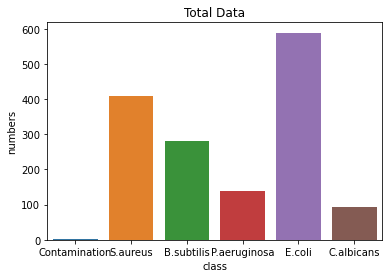

In [3]:
root = '../inputData/single/'
class_path = os.listdir(root)
data_path = []
counts = []

for i in range(len(class_path)):
    data_path.append(os.path.join(root,class_path[i]))
    counts.append(len(os.listdir(data_path[i]))/2)

# print(data_path)
label_dict = {0: 'Contamination',1 :'S.aureus' ,2 : 'B.subtilis',3: 'P.aeruginosa', 4:'E.coli', 
              5:'C.albicans'}


print(counts,sum(counts))
ax = sns.barplot(x = list(label_dict.values()),y = counts)
ax.set_xlabel("class")
ax.set_ylabel("numbers")
ax.set_title("Total Data")
# df = pd.DataFrame(columns={})


## Prepare the dataset

In [2]:
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from collections import OrderedDict


In [5]:
# print(os.listdir(data_path[0]))
img = []
label = []
for i in range(len(data_path)):
    for im in os.listdir(data_path[i]):
        if im.endswith(".png"):
            img.append(im)
            label.append(i)

di = {"image_name":img,"label":label}
# print(di["image_name"][:10])
df = pd.DataFrame(data=di)
df.head()
# df.to_csv("anno_data.csv")
        

,image_name,label
0,2019-07-18_04961_1.png,0
1,2019-07-18_04961_4.png,0
2,2019-04-21_01017_0.png,1
3,2019-04-21_01017_1.png,1
4,2019-04-21_01017_10.png,1


In [6]:
class CustomImageDataset(data.Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir[int(self.img_labels.iloc[idx, 1])], 
                                self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
        # image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [7]:

# standard transform
transform = transforms.Compose([transforms.Resize(224),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])
                                ])

# augmentation transform
transform_train = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomVerticalFlip(p=0.5),
                                      transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(
                                          224, scale=(0.4, 1), ratio=(3/4, 4/3)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])
                                      ])
total_data = CustomImageDataset("anno_data.csv",data_path,transform=transform_train)

train_size = int(len(total_data)*0.8)
test_size = len(total_data)-train_size
train_data,test_data = data.random_split(total_data,[train_size,test_size])

train_loader = data.DataLoader(train_data,batch_size=1,shuffle=True,num_workers=1)
test_loader = data.DataLoader(test_data,batch_size=128,shuffle=True,num_workers=1)
print(train_size,test_size)

# total_dataloader = data.DataLoader()


1210 303


RuntimeError: DataLoader worker (pid(s) 23188) exited unexpectedly

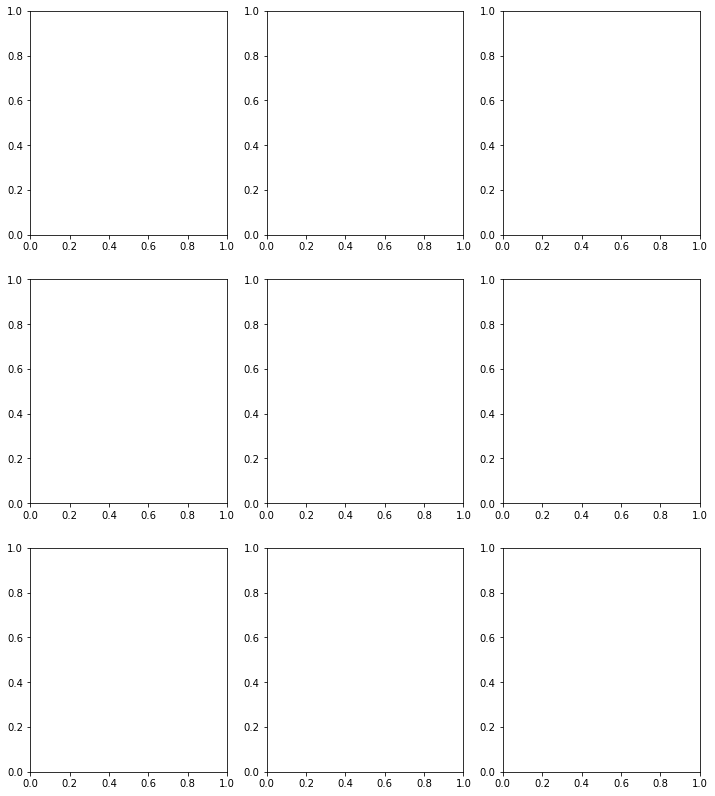

In [8]:
def visualize_images(dataloader):
    mean=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])
    figure, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 14))
    img_no = 0
    for images,labels in dataloader:
        for i in range(3):
            for j in range(3):
                img = np.array(images[img_no]).transpose(1,2,0)
                lbl = labels[img_no]                
                ax[i,j].imshow((img*std) + mean)
                ax[i,j].set_title(label_dict[int(lbl)])
                ax[i,j].set_axis_off()
                img_no+=1
        break
visualize_images(train_loader)

## Network Design

In [2]:
from torchvision import models
efficientnet =  models.shufflenet_v2_x0_5(pretrained=True)

AttributeError: module 'torchvision.models' has no attribute 'efficientnet'

In [24]:
alexNet = models.alexnet(pretrained=True)
vgg16 = models.vgg16(pretrained=True)
resNet = models.resnet18(pretrained=True)
densNet = models.densenet121(pretrained=True)
efficientNet = models.mobilenet_v2(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to C:\Users\GTT/.cache\torch\hub\checkpoints\alexnet-owt-4df8aa71.pth
100%|██████████| 233M/233M [00:49<00:00, 4.95MB/s] 
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\GTT/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [02:23<00:00, 3.87MB/s]   


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = resNet
classifier = nn.Sequential(OrderedDict([
    ('fc0', nn.Linear(1920, 256)),
    ('norm0', nn.BatchNorm1d(256)),
    ('relu0', nn.ReLU(inplace=True)),
#     ('drop0', nn.Dropout(p=0.2)),
    ('fc1', nn.Linear(256, 6))
]))

model.classifier = classifier

model.to(device)

NameError: name 'resNet' is not defined

In [7]:
from sklearn import metrics
@torch.no_grad()
def predict(model,data_loader):
    labels = []
    preds = []
    for x,y in data_loader:
        x = x.to(device)
        y = y.to(device)
        z = model(x)
        _,pred = torch.max(z.data,1)
        preds = np.concatenate(preds,pred.to('cpu'),axis=-1)
        labels = np.concatenate(labels,y.to('cpu'),axis=-1)
    return labels,preds

def evalation(model,data_loader):
    label, pred = predict(model,data_loader)
    accs = metrics.accuracy_score(y_true=label,y_pred=pred)
    b_accs = metrics.balanced_accuracy_score(y_true=label,y_pred=pred)
    f1s = metrics.f1_score(y_true=label,y_pred=pred)
    report = metrics.classification_report(y_true=label,y_pred=pred)
    confusion_matrix = metrics.confusion_matrix(label,pred) 
    return accs,b_accs,f1s,report,confusion_matrix

In [17]:
mean_num = np.mean(sum(counts)/len(counts))
class_weight = [mean_num/num for num in counts]
# print(mean_num,class_weight)
class_weight[0] = 0.1
print(class_weight)
lr = 1e-3
weight_decay = 1e-4
momentum = 0.96
max_epoch = 100
criterion = nn.CrossEntropyLoss(weight=class_weight)
optimizer = torch.optim.SGD(model.classifier.parameters(),lr=lr,weight_decay=weight_decay,momentum=momentum)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=30,gamma=0.1)
costs = []
train_accs = []
test_accs = []
b_accs = []
f1_scores = []


[0.1, 0.6154471544715447, 0.8979833926453143, 1.815347721822542, 0.42840973401245047, 2.7132616487455197]


In [ ]:
def train(model, train_loader, test_loader, max_epoch=100, test_period=5, early_threshold=5):
    """ train with a scheduler on learning rate

    Args:
        test_period (int): period of test
        early_threshold (int): threshold for early stoppig strategy, which pays attention to acc on test set
    """
    N_train = len(train_loader.dataset)
    patience = early_threshold
    
    # make sure the model is in the training mode
    model.train()

    for epoch in range(max_epoch):
        cost = 0
        correct = 0
        
        for x, y in train_loader:
            # setting GPU
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            
            cost += loss.item()
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y).sum().item()
            
        cost /= len(train_loader) # average cost
        costs.append(cost)
        

        # ! acc on train in train mode
        acc = correct / N_train
        train_accs.append(acc)

        # adjsut learning rate
        scheduler.step()

        if epoch % test_period == 0:
            test_acc, test_b_acc, test_f1,_,_ = evalation(model,test_loader)

            test_accs.append(test_acc)
            b_accs.append(test_b_acc)
            f1_scores.append(test_f1)
            # if eval_metrics.acc >= eval_metrics.best_score:
            #     eval_metrics.best_score = eval_metrics.acc
            #     patience = early_threshold
            # else:
            #     patience -= 1
            #     if patience == 0:
            #         break
            
            print("{:3d} cost: {:.4f}\ttrain_acc: {:.4f}\ttest_acc: {:.4f}\ttest_bacc: {:.4f}\tf1_score: {}".format(
                epoch, cost, acc, test_accs[-1], b_accs[-1], f1_scores[-1]))

            # change back to training mode    
            model.train()

## Evaluation

In [8]:
# def draw_matrix(matrix):
model = torch.load("denseNet-1.pkl",map_location='cpu')
train_y, train_pred = predict(model,train_loader)
confusion_matrix = metrics.confusion_matrix(train_y,train_pred)


NameError: name 'train_loader' is not defined

In [ ]:
plt.figure(figsize=(10,6),dpi=100)
plt.plot(train_accs,label='train')
plt.plot(test_accs,label='test')
plt.plot(b_accs,label='balanced on test')
plt.plot(costs,label='costs')
plt.xlabel('epoch')
plt.ylabel('accs-costs')
plt.legend()
plt.title('Accuracy-Cost')
plt.show()

